# Analyze letter sequence data.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.ticker import PercentFormatter
import statistics
from scipy.stats import skew 
from scipy.stats import ttest_ind
import math as m
import scipy.stats as st
plt.style.use('seaborn')
plt.style.use('seaborn-talk')
pd.set_option('display.max_columns', 50)

## Load the data file.

In [2]:
import csv 

filename = 'participant_anagram_sequence.csv'
sequence_list_letter = list()
with open(filename, mode ='r') as file: 
    filecontents = csv.reader(file) 
    for line in filecontents:
        #print(line)
        sequence_list_letter.append(line)

# Note: sequence_list_letter is a list of list:
# [
#   ['P22', 'HAKCL', 'HAKCLHAKCHLCHAK'], 
#   ['P22', 'NOBWR', 'OBONRWRWNBRNOBRONWNOBORNRBRNW'],
#   etc, etc...
# ]

len(sequence_list_letter)

202

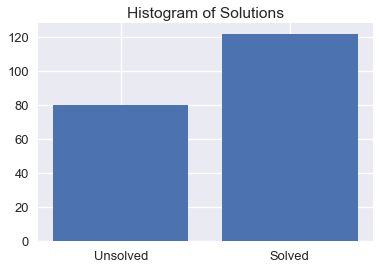

In [5]:
# Load the data about whether participants solved the anagram or not.
df = pd.read_csv('solution_participant_data.csv')

solved_list = list()
for row in sequence_list_letter:
    Part_Word = row[0]+'_'+row[1]
    # Make sure that the order of solved_list is 
    # the same as sequence_list_letter array.
    sol = df[df['Participant_Word']==Part_Word]['1=Solved'].values
    solved_list.append(sol)
    
# Histogram of performance
arr = solved_list
labels, counts = np.unique(arr, return_counts=True)
plt.bar(labels, counts, align='center')
plt.title('Histogram of Solutions')
plt.xticks((0,1),('Unsolved','Solved'))
plt.gca().set_xticks(labels)
plt.show()

In [8]:
# List of anagram answers.
total_word_list = ['FLAWED', 'CLOSED', 'ADMIRE', \
                   'JUNIOR', 'BETRAY', 'PEANUT', \
                   'MODEST', 'MAKEUP', \
                   'CHALK', 'POWER', 'BROWN', 'COURT']


# Return a word that is a solution to the set of letters.
def check_letters_word_list(letters, word_list):
    for word in word_list:
        if check_letters_one_word(letters, word) is True:
            return word 


def check_letters_one_word(letters, word):
    # Easier check: sort the array of characters and compare.
    is_word = True
    for letter in letters:
        if letter not in word:
            is_word = False
    return is_word

# sequence_list_letter_order: list of numbers representing the order of
#                             letters in the un-scrambled word.

sequence_list_letter_order = list()
for row in sequence_list_letter:
    sequence_list_letter_order_row = [row[0]+'_'+row[1]]
    letters = row[1] # anagram characters
    word = check_letters_word_list(letters, total_word_list)
    #print("%s -> %s"%(letters,word))
    sequence = [value for value in row[2]]
    for i, letter in enumerate(word):
        for j in range(len(sequence)):
            if sequence[j] == letter:
                sequence[j] = i + 1
    sequence_list_letter_order_row.append(sequence)
    sequence_list_letter_order.append(sequence_list_letter_order_row)

In [9]:
# Show an example of letter sequence.
example_data = 50

print('Example Data')
print(sequence_list_letter_order[example_data][0])

letters = sequence_list_letter_order[example_data][0][4:]
word = check_letters_word_list(letters, total_word_list)
print("Anagram: %s -> %s"%(letters,word))

print(sequence_list_letter[example_data][2])

tmp = ''
for i in sequence_list_letter_order[example_data][1]:
    tmp = tmp+str(i)
print(tmp)

Example Data
P12_ADLWEF
Anagram: ADLWEF -> FLAWED
DAFEWLDADLEWLDAFEADALWFEADLWLDAWFEFADLWEFELDAFLEWFADLWEFADLAEWFEFADLDLAFWALDAFWFEFADLWFEDLDAWFEWEFDLDAFADLWFEDWDAEFLWDAFEFDLWAFEAFLWLADFELDLAFEWLDAFEWLDADLWEFADLDAEFWLDAWLDAFEDLAFEWLDLWFAFEDLAFEWLDLWDLDAFEDAEFADLWLDAFEDLWLDAFLDAWDAFEDLDADEF
631542636254263153632415362426341513624515263125413624513623541513626231432631415136241562634154516263136241564635124631516243153124236152623154263154263624513626351426342631562315426241315623154262462631563513624263156242631263463156263651


## Statistics




Make a bunch of parallel np arrays (total length of 202, unless we cut more out for some reason). Did people have a bias towards some two or three letter combination, what would those have been? Presumeably that can't be accounted for by the position of the letters on the screen because they were randomized (albeit with a low chance of in-sequence letters showing up next to each other). Do people tend to try to spell out words within the shuffled word? How does the proportion of in-sequence letters change over time? (We'll probably have to trim down the very short ones. I'm thinking of making ten deciles so to speak, so we'll need letter sequences at least 10 long. 

In [54]:

def find_norm_loc (data_row,target):
    data_len = len(data_row)
    target_len = len(target)

    # if target is [-2,-1], this is the last bigram.
    # The following code would fail if the subject did not 
    # look at the last letter, but this probably never happened.
    maxval = max(data_row)
    for i in range(target_len):
        if target[i]<0: # if the index is given as a negative.
            target[i] = target[i]+maxval+1
            
    loc_list = list()
    for i in range(data_len-target_len+1):
        if data_row[i:i+target_len]==target:
            loc_list.append(float(i)/float(data_len-target_len))
    return loc_list

# Find normalized (between 0 and 1) location of Ngrams.
# sol1 = solved anagram
# sol0 = unsolved anagram
norm_loc_first_2gram_sol1 = list()
norm_loc_first_2gram_sol0 = list() 
avg_sol1 = list()
avg_sol0 = list()

minimum_data_len = 21
for i,data in enumerate(sequence_list_letter_order):
    data_row = data[1]
    if len(data_row)>minimum_data_len:
        norm_loc = find_norm_loc(data_row,[1,2]) # First bigram
        #norm_loc = find_norm_loc(data_row,[-2,-1]) # Last bigram
        #norm_loc = find_norm_loc(data_row,[2,1]) # Reverse of first bigram
        if len(norm_loc)>0:
            norm_loc_avg = sum(norm_loc)/len(norm_loc)
            if solved_list[i]==0:
                norm_loc_first_2gram_sol0.append(norm_loc)
                avg_sol0.append(norm_loc_avg)
            else:    
                norm_loc_first_2gram_sol1.append(norm_loc)
                avg_sol1.append(norm_loc_avg)

avg_sol1 = np.array(avg_sol1)
avg_sol0 = np.array(avg_sol0)

In [55]:
# Test find_norm_loc function.
print('Testing find_norm_loc function')
print('The answer should be: [0.0, 0.5, 1.0]')
print(find_norm_loc([1,2,3,1,2,2,1,2],[1,2]))
print(find_norm_loc([5,6,3,5,6,2,5,6],[-2,-1]))

Testing find_norm_loc function
The answer should be: [0.0, 0.5, 1.0]
[0.0, 0.5, 1.0]
[0.0, 0.5, 1.0]


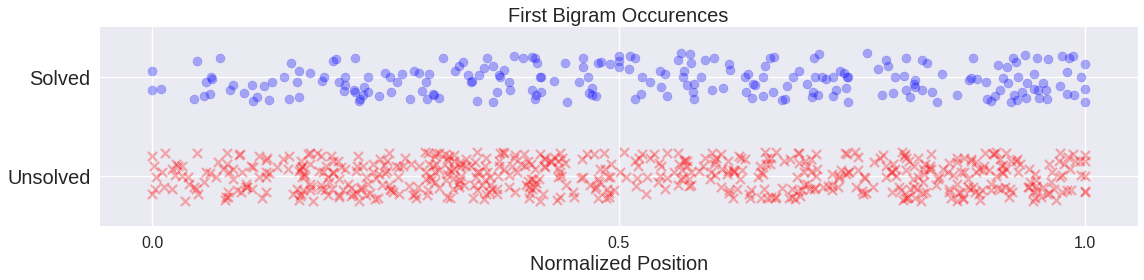

In [56]:
# Scatterplot of normalized location of first bigrams.

plt.figure(figsize=(16,4))

spread = 0.5

flatlist0 = list()
flatlist1 = list()

for i,loc in enumerate(norm_loc_first_2gram_sol0):
    for j in loc:
        flatlist0.append(j)
    N = len(norm_loc_first_2gram_sol0)
    j = ((i-N/2)/N)*spread + 0
    plt.scatter(loc,[j]*len(loc),alpha=0.3,marker='x',color='red')
for i,loc in enumerate(norm_loc_first_2gram_sol1):
    for j in loc:
        flatlist1.append(j)
    N = len(norm_loc_first_2gram_sol1)
    j = ((i-N/2)/N)*spread + 1
    plt.scatter(loc,[j]*len(loc),alpha=0.3,marker='o',color='blue')

plt.ylim((-0.5,1.5))
plt.yticks((0,1),('Unsolved','Solved'),fontsize=20)
#plt.xticks((0,1),('Begin','End'),fontsize=16)
plt.xticks((0,0.5,1),fontsize=16)
plt.xlabel('Normalized Position',fontsize=20)
plt.title('First Bigram Occurences',fontsize=20)
plt.tight_layout()
plt.savefig('loc_first_bigram.png',dpi=600)
plt.show()

Sol=0: 0.5117 with std 0.1360
Sol=1: 0.5862 with std 0.1919
error bar = 95% confidence interval


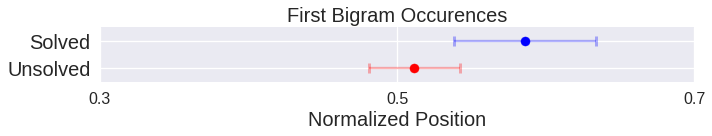

In [57]:
# Average of normalized locations.
print('Sol=0: %5.4f with std %5.4f'%(np.mean(avg_sol0),np.std(avg_sol0)))
print('Sol=1: %5.4f with std %5.4f'%(np.mean(avg_sol1),np.std(avg_sol1)))
conf_interval0 = st.t.interval(0.95, len(avg_sol0)-1, loc=np.mean(avg_sol0), scale=st.sem(avg_sol0))
conf_interval1 = st.t.interval(0.95, len(avg_sol1)-1, loc=np.mean(avg_sol1), scale=st.sem(avg_sol1))
print('error bar = 95% confidence interval')
plt.figure(figsize=(10,2))
plt.scatter(np.mean(avg_sol0), 0, color='red')
plt.errorbar(np.mean(avg_sol0), 0, xerr=np.diff(conf_interval0)/2, alpha=0.3,capsize=5, capthick=3, color='red')
plt.scatter(np.mean(avg_sol1), 1, color='blue')
plt.errorbar(np.mean(avg_sol1), 1, xerr=np.diff(conf_interval1)/2, alpha=0.3,capsize=5, capthick=3, color='blue')
plt.ylim((-0.5,1.5))
plt.xlim((0.5,0.7))
plt.yticks((0,1),('Unsolved','Solved'),fontsize=20)
plt.xticks((0.3,0.5,0.7),fontsize=16)
plt.xlabel('Normalized Position',fontsize=20)
plt.title('First Bigram Occurences',fontsize=20)
plt.tight_layout()
plt.savefig('loc_first_bigram_avg.png',dpi=600)
plt.show()

ttest on all locations.
0.12598207106056886
ttest on average of each trial
0.010100208400063673


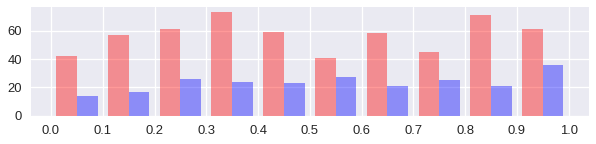

In [58]:
# Plot distribution of normalized positions.
plt.figure(figsize=(10,2))
plt.hist([flatlist0,flatlist1],bins=10,range=(0,1),color=('red','blue'),alpha=0.4)
plt.xticks(np.arange(0,1.01,0.1))

print("ttest on all locations.")
t,pval = ttest_ind(flatlist0, flatlist1, equal_var=False)
print(pval)

print("ttest on average of each trial")
t,pval = ttest_ind(avg_sol0, avg_sol1, equal_var=False)
print(pval)

## Correlate with bigram statistics

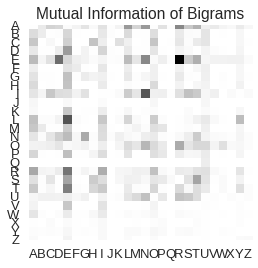

In [81]:
# Load bigram mutual information (26x26 matrix).
alphabets_str = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
alphabets = [a for a in alphabets_str]
N = len(alphabets)

filename = '../nGramEntropy/mutinfo_bigram.csv'
mi_bigram = np.loadtxt(filename,delimiter=',')

plt.figure(figsize=(4,4))
plt.imshow(mi_bigram,interpolation='none')
plt.xticks(range(N),labels=alphabets)
plt.yticks(range(N),labels=alphabets)
plt.grid(b=None)
plt.title('Mutual Information of Bigrams')
plt.show()

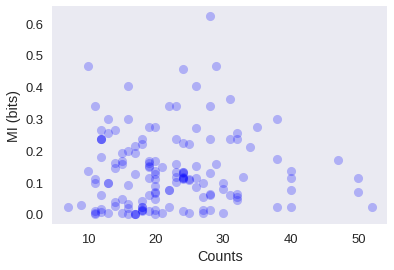

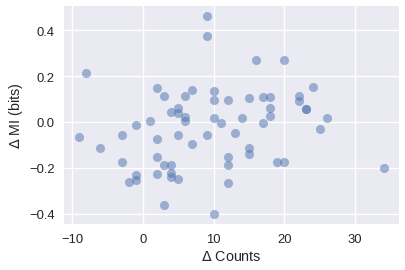

In [145]:
sum_stat = list()
Ndata = len(sequence_list_letter)
for ex in range(Ndata):

    anagram = sequence_list_letter[ex][1]
    seq = sequence_list_letter[ex][2]

    bigram0 = anagram[0]+anagram[1]
    bigram1 = anagram[1]+anagram[2]

    bigram_list = list([bigram0,bigram1])
    #if solved_list[ex]==0:
    if (len(seq)>200) and (solved_list[ex]==0):
        counts = np.zeros(len(bigram_list))
        mivals = np.zeros(len(bigram_list))
        for i,target_bigram in enumerate(bigram_list):
            # For each bigram of interest, count the number of times
            # that this bigram appears in the sequence.
            for j in range(len(seq)-1):
                curr_bigram = seq[j:j+2]
                if curr_bigram==target_bigram:
                    counts[i] = counts[i]+1

            # Extract the MI value from the matrix.
            idx0 = alphabets_str.find(target_bigram[0])
            idx1 = alphabets_str.find(target_bigram[1])
            mivals[i] = mi_bigram[idx0,idx1]

            plt.plot(counts[i],mivals[i],'o',color='blue',alpha=0.25)
            #print('%s: counts=%d, MI=%5.4f'%(target_bigram,counts[i],mivals[i]))
        diff_mivals = mivals[1]-mivals[0]
        diff_counts = counts[1]-counts[0]
        
        if (diff_mivals != 0) & (diff_counts != 0):
            sum_stat.append([diff_mivals,diff_counts])
        #ratio_mivals[ex] = mivals[1]/(mivals[0]+1)
        #ratio_counts[ex] = counts[1]/(counts[0]+1)  

sum_stat = np.array(sum_stat)

plt.xlabel('Counts')
plt.ylabel('MI (bits)')
plt.grid(b=None)
plt.savefig('MI_vs_counts_bigrams.png')
plt.show()

#plt.hist(np.array(sum_stat)[:,1])
plt.plot(sum_stat[:,1],sum_stat[:,0],'o',alpha=0.5)
plt.ylabel('$\Delta$ MI (bits)')
plt.xlabel('$\Delta$ Counts')
plt.show()